# SME0878 - Mineração Estatística de Dados
## Instituto de Ciências Matemáticas e Computação - Unversidade de São Paulo

* Alef Segura Santos, 9762942
* Gustavo de Moura Souza, 9762981

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

sns.set(style="whitegrid")

### 1 – Considere	a	base	de	dados:
https://www.kaggle.com/fschwartzer/tmd-dataset-5-seconds-sliding-window

In [2]:
# Leitura dos datasets:
dataset = pd.read_csv('dataset_5secondWindow%5B1%5D.csv')
dataset.shape

(5893, 14)

### 2 – Realize o pré-processamento dos	dados:
Verifque se há NaN	ou	outros	erros no dados.<br>Selecione  apenas os atributos relevantes	e numéricos.

In [3]:
# Removendo colunas não numéricas
to_drop = [t for t in dataset.iloc[:,:-1].dtypes.index if dataset.dtypes[t] not in ['float32','int32','float64','int64']] 
dataset.drop(to_drop,axis=1)

# Removendo linhas duplicadas
dataset.drop_duplicates(inplace=True)

# Imputando valores nulos
dataset.fillna(dataset.mean(), inplace=True)

# Shape
dataset.shape

(5893, 14)

### 3 – No	caso	do	classificador	Knn,	verifique	o	efeito	do	parâmetro	k	na	classificação.

In [4]:
# Separação do Dataset (também serão utilizados em todos os modelos posteriores a este):
X = dataset.drop(['target'],axis=1).drop_duplicates()
y = dataset.target

# Separação de datasets para treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

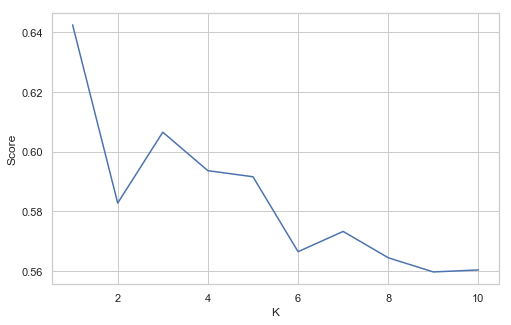

In [5]:
# Desempenho do algorítmo KNN, medido pela acurácia, em função do hiperparâmetro k:

# Valores de K
K = range(1,11)

# Teste dos modelos
scores = []
for k in K:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    scores.append(knn.score(X_test,y_test))

# Resultados
plt.figure(figsize=(8,5))
sns.lineplot(K, scores, markers=True, dashes=False)
plt.ylabel('Score')
plt.xlabel('K')
plt.show()

### 4 – Compare	os classificadores:
* knn (melhor	k	observado	no	item	anterior)
* Naive	Bayes
* Decisão	Bayesiana

In [6]:
# Classificador de Decisão Bayesiana:

class DecisaoBayesiana:
    
    def fit(self, train_x, train_y):
        from scipy.stats import multivariate_normal
        import numpy as np
        import pandas as pd
        
        if type(train_x) != np.ndarray:
            self.train_x = train_x.values
        else:
            self.train_x = train_x
            
        if type(train_y) != np.ndarray:
            self.train_y = train_y.values
        else:
            self.train_y = train_y
            
        return self
        
    def score(self, test_x, test_y):
        from sklearn.metrics import accuracy_score
        from scipy.stats import multivariate_normal
        
        train_x = self.train_x
        train_y = self.train_y
        
        if type(test_x) != np.ndarray:
            test_x = test_x.values
        else:
            test_x = test_x
            
        if type(test_y) != np.ndarray:
            test_y = test_y.values
        else:
            test_y = test_y
            
        classes = y_train.unique()
        P = pd.DataFrame(data=np.zeros((test_x.shape[0], len(classes))), columns=classes)
        
        for i in np.arange(0, len(classes)):
            elements = tuple(np.where(train_y == classes[i]))
            Z = train_x[elements,:][0]
            m = np.mean(Z, axis = 0)
            cv = np.cov(np.transpose(Z))
            for j in np.arange(0,test_x.shape[0]):
                x = test_x[j,:]
                pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
                P[classes[i]][j] = pj
        
        pred_y = []
        for i in np.arange(0, test_x.shape[0]):
            c = np.argmax(np.array(P.iloc[[i]]))
            pred_y.append(classes[c])

        return accuracy_score(test_y, pred_y)

In [7]:
# Seleção de modelos a serem testados:
models = [
    DecisaoBayesiana(),
    KNeighborsClassifier(n_neighbors=1),
    GaussianNB()
]

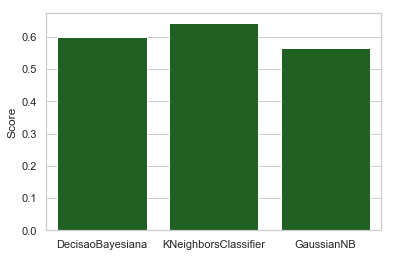

In [8]:
# Desempenho dos algoritmos testados, medido pela acurácia:
scores = []
for model in models:
    model.fit(X_train,y_train)
    scores.append(model.score(X_test,y_test))

# Resultados
sns.barplot(x=[type(m).__name__ for m in models], y=scores, color="green", saturation=.5);
plt.ylabel('Score')
plt.show()

### 5 – Verifique	o	efeito	da	normalização (atributos	em	[0,1])	e	padronização (atributos	com	média	0	e	variância	1)	dos	dados.	Compare	os	casos	sem	processamento,	com	padronização	e	com	normalização	para	os	classificadores:
* knn	(melhor	k	observado	no	item	anterior)
* Naive	Bayes
* Decisão	Bayesiana

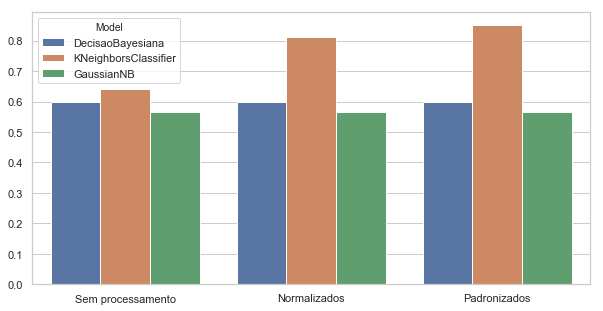

In [9]:
# Desempenho dos modelos testados, medido pela acurácia, com o mesmo conjunto de dados com diferentes pré-processamentos:

# Normalização (min=0 max=1)
X_norm = MinMaxScaler().fit_transform(X)

# Padronização (mean=0 std=1)
X_padr = StandardScaler().fit_transform(X)

# Teste dos modelos
scores = []
for X_currrent,dataset_name in zip([X, X_norm, X_padr],['Sem processamento','Normalizados','Padronizados']):
    X_current_train, X_current_test, y_current_train, y_current_test = train_test_split(X_currrent,y,random_state=42)
    for model in models:
        model.fit(X_current_train,y_current_train)
        score = model.score(X_current_test,y_current_test)
        scores.append({'Model':type(model).__name__, 'dataset':dataset_name,'score':score})
scores_df = pd.DataFrame(scores)

# Resultados
plt.figure(figsize=(10,5))
sns.barplot(x=scores_df.dataset, y=scores_df.score.values, hue=scores_df.Model);
plt.xlabel('')
plt.show()

### 6	– Mostre	a	matriz	de	correlação	entre	os	atributos.	Considere	os	atributos	com	menor orrelação	(por	exemplo,	menor	do	que	0.5).	Realize	a	classificação novamente	apenas	com	esses	atributos.	A acurácia	melhora?

In [10]:
corr = dataset.iloc[:,:-1].corr()
to_drop = np.unique([c for c in corr for i in corr[c] if i<1.0 and i>0.9])

# Matriz de correlação entre novas as variáveis:
X_low_corr = dataset.iloc[:,:-1].drop(to_drop,axis=1)
y_low_corr = dataset.iloc[:,-1]

print(X_low_corr.shape)
print(y_low_corr.shape)

(5893, 7)
(5893,)


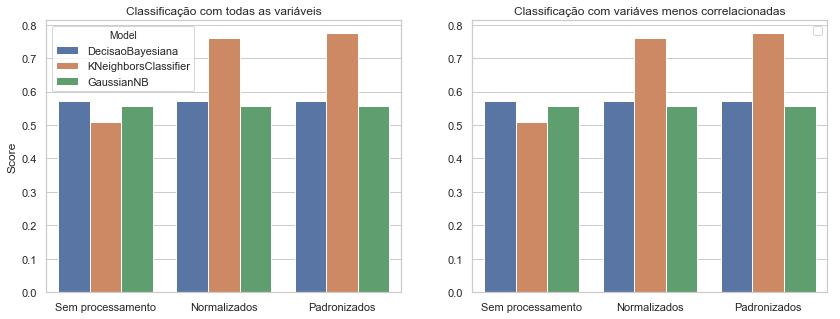

In [17]:
# Normalização (min=0 max=1)
X_low_corr_norm = MinMaxScaler().fit_transform(X_low_corr)

# Padronização (mean=0 std=1)
X_low_corr_padr = StandardScaler().fit_transform(X_low_corr)

# Teste dos modelos
scores = []
for X_currrent,base in zip([X_low_corr, X_low_corr_norm, X_low_corr_padr],
                           ['Sem processamento','Normalizados','Padronizados']):
    X_current_train, X_current_test, y_current_train, y_current_test = train_test_split(X_currrent,y,random_state=42)
    for model in models:
        model.fit(X_current_train,y_current_train)
        score = model.score(X_current_test,y_current_test)
        scores.append({'Model':type(model).__name__, 'dataset':base,'score':score})
scores_df_low_corr = pd.DataFrame(scores)

# Resultado
plt.figure(figsize=(14,5))

ax = plt.subplot(121)
sns.barplot(x=scores_df_low_corr.dataset, y=scores_df_low_corr.score.values, hue=scores_df_low_corr.Model);
plt.xlabel('')
plt.ylabel('Score')
plt.title('Classificação com todas as variáveis')

plt.subplot(122, sharey=ax)
sns.barplot(x=scores_df_low_corr.dataset, y=scores_df_low_corr.score.values, hue=scores_df_low_corr.Model);
plt.xlabel('')
plt.legend([])
plt.title('Classificação com variáves menos correlacionadas')

plt.show()

### 7	– Verifique	qual	dos	classificadores	é	mais	robusto	com	relação	à	presença	de	ruídos.	Para	isso:	
* Aplique	a	normalização	dos	dados	para	que	os	atributos	apresentem	média	igual	a	zero	e	variância	igual	a	1.
* Inclua	em	X%	dos	atributos,	um	valor	normalmente	distribuído	com	média	0	e	variância 1. Considere	toda	a	matriz	dos	dados,	sorteando uma	posição	da	matriz	de	forma	aleatória.

* Varie	o	nível	de	ruído,	de	0	a	50%	(em	passos	de	5%)	e	avalie	como	muda a	classificação.	Construa	um	gráfico	de	X% de	ruído versus	porcentagem	de	classificação	correta.	Coloque	a	média	e	o	desvio	padrão	calculados	a partir	de	ao	menos	10	simulações.	Considere	70%	dos	dados	no	conjunto de	treinamento.
* Discuta os	resultados.

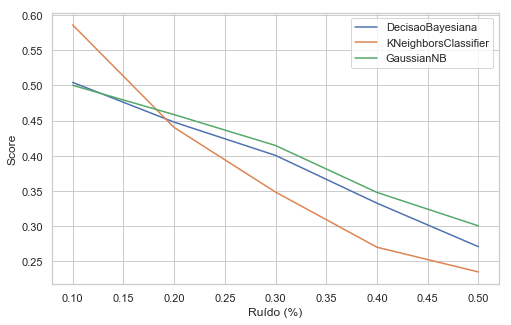

In [13]:
# Normalização:
X_ex7 = StandardScaler().fit_transform(X)

# Proporções de dados alterados
p_samples = np.linspace(0.1,0.5,5)

scores = []
for p_sample in p_samples:

    # Número de dados a serem alterados
    n_sample = int(p_sample * X_ex7.shape[0] * X_ex7.shape[1])
    lines_sample = np.random.randint(0, X_ex7.shape[0], n_sample)
    cols_sample = np.random.randint(0, X_ex7.shape[1], n_sample)

    # Amostras
    normal_sample = StandardScaler().fit_transform(np.random.normal(size=n_sample).reshape(-1,1))

    # Troca dos valores
    for i,j,x in zip(lines_sample, cols_sample, normal_sample):
        X_ex7[i][j] = x

    # Datasets e modelos
    X_ex7_train, X_ex7_test, y_ex7_train, y_ex7_test = train_test_split(X_ex7, y, train_size=0.3)
    
    scores_models = []
    for model in models:
        mod = model.fit(X_ex7_train,y_ex7_train)
        scores_models.append(mod.score(X_ex7_test,y_ex7_test))

    scores.append(scores_models)

# Resultados
plt.figure(figsize=(8,5))
[sns.lineplot(p_samples, np.array(scores)[:,i]) for i in range(0,len(models))]
plt.legend([type(m).__name__ for m in models])
plt.ylabel('Score')
plt.xlabel('Ruído (%)')
plt.show()

### 8 – No	caso	do	classificador	Naive	Bayes,	é	possível	considerar	diferentes funções	para	estimar	as	probabilidades.	Compare	os	casos:
1. Gaussian	Naive Bayes
2. multinomial	Naive	Bayes
3. Bernoulli	Naive	Bayes.
#### Considere os casos	com	e	sem	padronização.

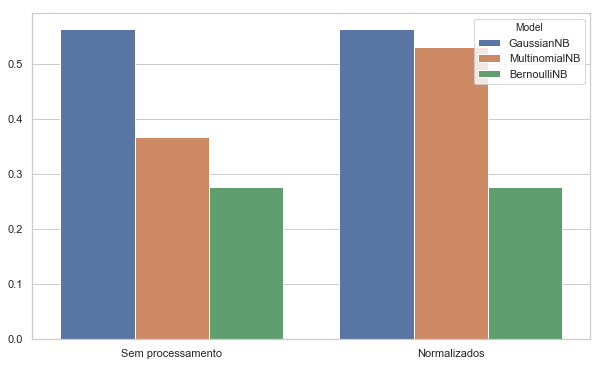

In [14]:
# Desempenho dos modelos gausianos, medido pela acurácia, com o mesmo conjunto de dados com diferentes pré-processamentos:

# Normalização (min=0 max=1)
X_norm = MinMaxScaler().fit_transform(X) 
                                         
# Seleção de modelos gausianos
gausian_models = [
    GaussianNB(),
    MultinomialNB(),
    BernoulliNB()
]

# Teste dos modelos
scores = []
for X_currrent,base in zip([X, X_norm],['Sem processamento','Normalizados']):
    X_current_train, X_current_test, y_current_train, y_current_test = train_test_split(X_currrent,y,random_state=42)
    for model in gausian_models:
        model.fit(X_current_train,y_current_train)
        score = model.score(X_current_test,y_current_test)
        scores.append({'Model':type(model).__name__, 'dataset':base,'score':score})
scores_df = pd.DataFrame(scores)

# Resultado
plt.figure(figsize=(10,6))
sns.barplot(x=scores_df.dataset, y=scores_df.score.values, hue=scores_df.Model);
plt.xlabel('')
plt.show()

### 9 – No	caso	do	Knn,	compare	as	classificações	usando	diferentes	métricas.	Varie	k	e	mostre	as	curvas	(em	um	mesmo	plot)	para	as	distâncias	euclidiana,	Manhattan,	Chebyshev e	Minkowsky	(p=0.5,	p=1.5,	p	=	3).


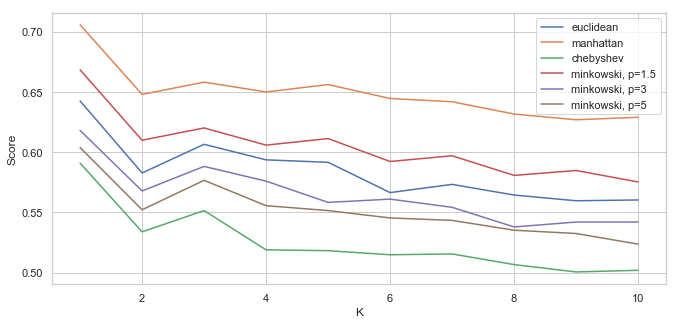

In [18]:
# Desempenho dos modelo KNN, medido pela acurácia, em função do hiperparâmetro k, com diferentes distâncias:

plt.figure(figsize=(11,5))

# Ks a serem utilizados pela curva
K = range(1,11)

# Distâncias
metrics = ['euclidean','manhattan','chebyshev']

# Testes dos modelos
for m in metrics:
    scores = []
    for k in K:
        knn = KNeighborsClassifier(n_neighbors=k, metric=m)
        knn.fit(X_train,y_train)
        scores.append(knn.score(X_test,y_test))
    sns.lineplot(K, scores)
    
for p in [1.5,3,5]:
    scores = []
    for k in K:
        knn = KNeighborsClassifier(n_neighbors=k,metric='minkowski',p=p)
        knn.fit(X_train,y_train)
        scores.append(knn.score(X_test,y_test))
    metrics.append('minkowski, p={}'.format(p))
    sns.lineplot(K, scores)

# Resultados
plt.legend(metrics)
plt.ylabel('Score')
plt.xlabel('K')
plt.show()

### 10	– Faça	um	gráfico	da	fração	de	elementos	no	conjunto	de	treinamento	(10% até	90%	em	passos	de	10%)	versus	acurácia	para	os	classificadores:
* knn	(melhor	k	observado	anteriormente)
* Naive	Bayes
* Decisão	Bayesiana
### Considere	os	casos	com	e	sem	padronização.

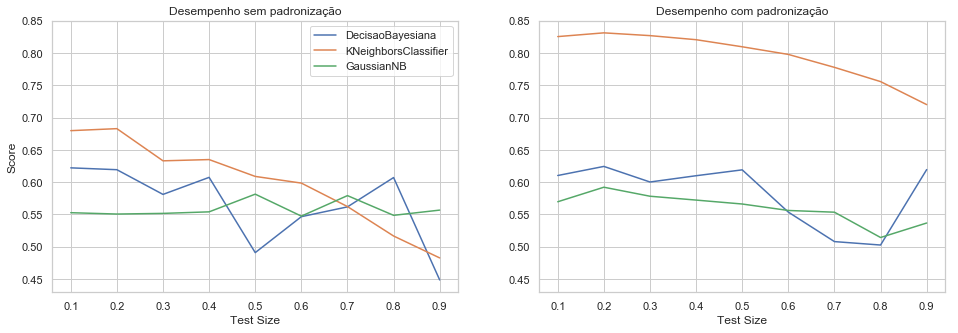

In [16]:
# Desempenho dos modelos testados, medido pela acurácia, em função do matanho do dataset de treinamento:

# Padronização (mean=0 std=1)
X_padr = StandardScaler().fit_transform(X)

# Valores para test_size
P = [i/10 for i in range(1,10)]

# Teste dos modelos sem padronizacao
scores = []
scores_padr = []
for p in P:
    
    # Sem padronização
    X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X,y,test_size=p)
    scores_models = []
    for model in models:
        model.fit(X_p_train,y_p_train)
        scores_models.append(model.score(X_p_test,y_p_test))
    scores.append(scores_models)
    
    # Com padronização
    X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_padr,y,random_state=0,test_size=p)
    scores_models = []
    for model in models:
        model.fit(X_p_train,y_p_train)
        scores_models.append(model.score(X_p_test,y_p_test))
    scores_padr.append(scores_models)
    
# Resultados
plt.figure(figsize=(16,5))

ax = plt.subplot(121)
[sns.lineplot(P, np.array(scores)[:,i]) for i in range(0,len(models))]
plt.title('Desempenho sem padronização')
plt.legend([type(m).__name__ for m in models])
plt.ylabel('Score')
plt.xlabel('Test Size')

plt.subplot(122, sharey=ax)
[sns.lineplot(P, np.array(scores_padr)[:,i]) for i in range(0,len(models))]
plt.title('Desempenho com padronização')
plt.xlabel('Test Size')

plt.show()